Figure 2.

In [1]:
%load_ext autoreload
%autoreload 2
%run nnn/ipynb_init.py
%matplotlib inline

from nnn.uv import *

# Prepare UV melting data for direct comparison

Aggregate to SEQID level and salt adjust to array salt level

In [2]:
# copy pasted from command center for convenience
# only one peak found by AnalyzePeaks
hplc_clean_seqid = ["WC68_stem_3p", "WC68_stem_5p", "WC1025_split_5p", \
"WC1025_split_3p", "WC1375_stem_5p", "WC1375_stem_3p", "DMM004_5p", \
"DMM004_3p", "DMM005_5p", "DMM005_3p", "DMM006_5p", "DMM007_5p", \
"DMM007_3p", "BC0", "BC1", "BC6", "BC7", "BC8", "BC9", "BC10", \
"BC11", "MMCNNN2328", "MMCNNN2331", "MMCNNN2334", "MMCNNN2335", \
"MMCNNN2336", "MMCNNN2337", "MMTM1325", "MMTM176", "MMTM178", \
"MMTM179", "MMTM181", "MMTM185", "MMTM189", "MMTM1917", "MMTM29", \
"MMTM397", "MMTM509", "MMTM877", "DMM003_3p_rc", "DMM004_3p_rc", \
"DMM005_3p_rc", "DMM006_3p_rc", "DMM007_3p_rc", "TETNN1003", \
"TETNN999", "TETNN963", "TETNN979", "TETNNN1696", "TETNNN2082", \
"TETNNN1570", "HP002", "HP003", "HP004", "HP005", "HP007", "HP008", \
"HP010", "HP011", "HP012", "HP014", "HP015", "HP016", "HP017", \
"HP018", "HP019", "HP021", "HP022", "HP023", "HP024"]

arr = pd.read_csv('./data/models/raw/arr_v1_n=27732.csv', index_col=0)
uv_oligos = pd.read_csv('./data/uv_melt/ECLTables/ECLOligos230502.csv').set_index('OligoID')

agg_result_file='./data/uv_melt/uvmelt_agg_230502.csv'
uv_df = pd.read_csv(agg_result_file, index_col=0)
uv_df = uv_df[uv_df.SEQID.isin(hplc_clean_seqid)]
uv_df = uv_df.query('is_hairpin').sort_values(by=['conc_uM', 'n_curve', 'curve_date'])

pname_uv = ['dG_37_uv', 'dH_uv', 'Tm_uv']
agg_list = [uv_df.groupby(['SEQID', 'Na_mM'])[p].apply(np.nanmedian) for p in pname_uv]
agg_df = pd.DataFrame(agg_list[0]).reset_index()

for i,p in enumerate(pname_uv):
    agg_df[p] = agg_list[i].values

agg_df = agg_df.set_index('SEQID').join(arr).join(uv_oligos['sequence'])

def adjust_uv_param(i, agg_df):    
    row = agg_df.iloc[i,:]
    if row.Na_mM > 25:
        adjusted_dict = util.get_Na_adjusted_param(
            Na=0.083, from_Na=(row.Na_mM + 50)/1000,
            dH=row.dH_uv, Tm=row.Tm_uv, seq=row.RefSeq)
        for p in ['dG_37', 'dH', 'Tm']:
            row[p+'_uv'] = adjusted_dict[p]
    return row
        
for i in range(len(agg_df)):
    agg_df.iloc[i,:] = adjust_uv_param(i, agg_df)

agg_df.drop(columns=['Na_mM'], inplace=True)
# agg_df.rename(columns=dict(sequence='RefSeq'), inplace=True)

In [127]:
agg_df.to_csv('./data/models/processed/uv_hairpin_arr_salt_hplc_filtered.csv')

In [109]:
agg_result_file='./data/uv_melt/uvmelt_agg_230502.csv'
uv_df = pd.read_csv(agg_result_file, index_col=0)

pname_uv = ['dG_37_uv', 'dH_uv', 'Tm_uv']
agg_list = [uv_df.groupby(['SEQID', 'Na_mM', 'is_hairpin'])[p].apply(np.nanmedian) for p in pname_uv]
agg_df = pd.DataFrame(agg_list[0]).reset_index()

for i,p in enumerate(pname_uv):
    agg_df[p] = agg_list[i].values

agg_df = agg_df.set_index('SEQID').join(arr)
        
for i in range(len(agg_df)):
    agg_df.iloc[i,:] = adjust_uv_param(i, agg_df)

agg_df.drop(columns=['Na_mM'], inplace=True)

agg_df.to_csv('./data/models/processed/uv_arr_salt_not_hplc_filtered.csv')

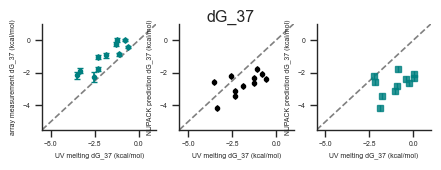

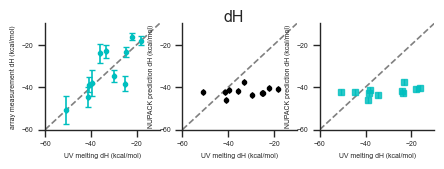

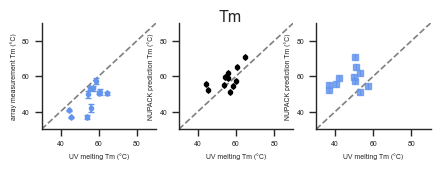

In [102]:
# for export
series = 'All'
plot_query = 'n_curve > 0'
df_q = agg_df.dropna(subset=['Tm', 'dG_37'])#.query(plot_query)
df_q[['dG_37_uv_std', 'Tm_uv_std', 'dH_uv_std']] = 0

def mae_norm(x, xerr, y):
    epsilon = 1e-2
    aerr = np.abs(x - y)
    return np.mean(aerr / (xerr + epsilon))

def plot_uv_comparison(df_q, param, lim, array_suffix=''):
    unit_dict = dict(dH='kcal/mol', dS='kcal/mol', dG_37='kcal/mol', Tm='°C')
    color_dict = dict(dH='c', Tm='cornflowerblue', dG_37='teal', dS='steelblue')
    param_name_dict = dict(dH=r'$dH°$', dS=r'$dS°$', dG_37=r'$dG°_{37}$', Tm=r'$T_m$')
    unit = unit_dict[param]
    param_name = param_name_dict[param]
    
    kwargs = dict(fmt = '.', alpha=1, marker='o', markersize=3, capsize=2)
    
    fig, ax = plt.subplots(1, 3, figsize=(3*4.25*cm, 3.5*cm))
    x = df_q[param + '_uv']
    y = df_q[param+array_suffix]
    xerr = df_q[param+'_uv_std'].values
    ax[0].plot(lim, lim, '--', c='gray')
    ax[0].errorbar(x, y,
                   xerr=xerr, yerr=df_q[param+'_se'],
                   color=color_dict[param], **kwargs)
    ax[0].set_xlim(lim)
    ax[0].set_ylim(lim)
    ax[0].set_xlabel(f'UV melting {param} ({unit})', fontsize=tick_font_size)
    ax[0].set_ylabel(f'array measurement {param} ({unit})', fontsize=tick_font_size)
    # ax[0].set_title('Array Melt Measurement\ncorr = %.4f, MAE = %.4f' %
    #                 (pearsonr(x, y)[0], mae_norm(x, xerr, y)))
    
    x = df_q[param+'_uv'].values
    y = df_q[param+'_NUPACK_salt_corrected'].values
    ax[1].errorbar(x, y,
                   xerr=df_q[param+'_uv_std'],
                   color='k', **kwargs)
    ax[1].plot(lim, lim, '--', c='gray')
    ax[1].set_xlim(lim)
    ax[1].set_ylim(lim)
    ax[1].set_xlabel(f'UV melting {param} ({unit})', fontsize=tick_font_size)
    ax[1].set_ylabel(f'NUPACK prediction {param} ({unit})', fontsize=tick_font_size)
    # ax[1].set_title('NUPACK prediction\ncorr = %.4f, MAE = %4f' %
    #                 (pearsonr(x, y)[0], mae_norm(x, xerr, y)))

    x = df_q[param+array_suffix].values
    y = df_q[param+'_NUPACK_salt_corrected'].values
    kwargs['marker'] = 's'
    kwargs['markersize'] = 5
    kwargs['alpha'] = 0.8
    ax[2].errorbar(x, y,
               xerr=df_q[param+'_uv_std'],
               color=color_dict[param], **kwargs)
    ax[2].plot(lim, lim, '--', c='gray')
    ax[2].set_xlim(lim)
    ax[2].set_ylim(lim)
    ax[2].set_xlabel(f'UV melting {param} ({unit})', fontsize=tick_font_size)
    ax[2].set_ylabel(f'NUPACK prediction {param} ({unit})', fontsize=tick_font_size)
    # ax[2].set_title('Array Melt vs NUPACK prediction\ncorr = %.4f, MAE = %.4f' %
    #                 (pearsonr(x, y)[0], mae(x, y)))
    for i in range(3):
        ax[i].set_yticklabels(ax[i].get_yticklabels(), fontsize=tick_font_size)
        ax[i].set_xticklabels(ax[i].get_xticklabels(), fontsize=tick_font_size)

    plt.suptitle(param)
    sns.despine()
    # plt.show()
    
plot_uv_comparison(df_q, 'dG_37', lim = (-5.5, 1))
# util.save_fig(f'./fig/Fig2/Fig2b/{series}_dG_37.pdf')
plot_uv_comparison(df_q, 'dH', lim = (-60, -10))
# util.save_fig(f'./fig/Fig2/Fig2b/{series}_dH.pdf')
plot_uv_comparison(df_q, 'Tm', lim = (30, 90))
# util.save_fig(f'./fig/Fig2/Fig2b/{series}_Tm.pdf')
# plot_uv_comparison(df_q, 'dS', lim = (-.18, -.01))
# util.save_fig(f'./fig/Fig2/Fig2b/{series}_dS.pdf')